In [52]:
import pandas as pd
import numpy as np
from preprocess import base_data
from pathlib import Path
import hydra
import yaml
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import optuna
import os
from sklearn.metrics import log_loss
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import catboost as cb

pd.set_option('display.max_columns', None)


In [53]:
file_path = '../config/config.yaml'

# ファイルを開いて内容を読み込む
with open(file_path, 'r', encoding='utf-8') as file:
    yaml = yaml.safe_load(file)

# featuresリストを取得
features = yaml.get('features', [])

data = [pd.read_pickle(f"../features/{f}.pkl") for f in features]
data = pd.concat(data, axis=1)

In [54]:
# FranchiseCodeを非フランチャイズ（0または1）とフランチャイズ（それ以外）に分類する新しい列を作成
data['Franchise'] = ['Franchise' if code > 1 else 'Non-Franchise' for code in data['FranchiseCode']]

data['Franchise'] = data['Franchise'].astype('category')

# Generate combination features
data['Jobs_Created_per_Employee'] = data['CreateJob'] / data['NoEmp']
data['Jobs_Retained_per_Employee'] = data['RetainedJob'] / data['NoEmp']
data['Loan_Amount_per_Employee'] = data['DisbursementGross'] / data['NoEmp']

# Handle possible division by zero
data.replace([np.inf, -np.inf], np.nan, inplace=True)

data['City_Count'] = data.groupby('City')['City'].transform('count')
data['State_Count'] = data.groupby('State')['State'].transform('count')
data['BankState_Count'] = data.groupby('BankState')['BankState'].transform('count')
data['Sector_Count'] = data.groupby('Sector')['Sector'].transform('count')

# 各行の欠損値の数を計算
data['missing_values_count'] = data.isna().sum(axis=1)

In [55]:
for col in ['RevLineCr','LowDoc','BankState','DisbursementYear','DisbursementMonth','DisbursementDay','LoanProcessingPeriod','Jobs_Created_per_Employee','Jobs_Retained_per_Employee','Loan_Amount_per_Employee','BankState_Count']:
    mode = data[col].mode().iloc[0]
    data[col] = data[col].fillna(mode)

In [56]:
category_features = ['State', 'BankState', 'Sector', 'NewExist', 'UrbanRural', 'RevLineCr', 'LowDoc', 'Franchise', 'IsSameState']

# LabelEncoderのインスタンスを作成
label_encoders = {}

for col in category_features:
    # 各カテゴリー特徴量に対してLabelEncoderを適用
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # 必要に応じて、変換したラベルエンコーダーを保存

In [57]:
train = data[data["train"]==True].drop(columns="train")
test = data[data['train'] == False]
test = test.drop(['train','MIS_Status'],axis=1)


In [58]:
train['MIS_Status'] = train['MIS_Status'].astype('int')

In [59]:
train = train.drop('City',axis=1)
test = test.drop('City',axis=1)

In [60]:
X_train = train.drop('MIS_Status', axis=1)
y_train = train['MIS_Status']

# Further splitting the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
# パラメータ設定
n_splits = 5

# K-Foldクロスバリデーションの設定
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# OOF予測用の配列を用意（X_trainのサイズで初期化）
oof_predictions = np.zeros(X_train.shape[0])
oof_predictions_val = np.zeros(X_val.shape[0])  # X_val用のOOF予測

# 各フォールドでの訓練と予測
for train_index, val_index in kf.split(X_train):
    # 分割
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # RandomForestモデルの訓練
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train_fold, y_train_fold)

    # 検証データでの予測
    oof_predictions[val_index] = rf_model.predict_proba(X_val_fold)[:, 1]
    # X_valに対応する予測を保存
    oof_predictions_val[X_val.index.isin(val_index)] = rf_model.predict_proba(X_val[X_val.index.isin(val_index)])[:, 1]

# CatBoostモデルの訓練
cat_model = cb.CatBoostClassifier(verbose=0)
cat_model.fit(np.column_stack((X_train, oof_predictions)), y_train)

# 最終的な予測
final_predictions = cat_model.predict_proba(np.column_stack((X_val, oof_predictions_val)))[:, 1]


In [63]:
# テストデータに対するRandomForestの予測確率を計算
test_predictions_rf = rf_model.predict_proba(test)[:, 1]

# テストデータに新しい特徴として予測確率を追加
X_test_with_predictions = np.column_stack((test, test_predictions_rf))

# CatBoostモデルを使って最終的な予測を行う
final_test_predictions = cat_model.predict(X_test_with_predictions)

In [64]:
final_test_predictions

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [65]:
print(roc_auc_score(y_val, final_predictions))
total_cases = len(y_val)  # テストデータの総数
TP = (y_val == 1) & (final_predictions >= 0.5)  # True positives
FP = (y_val == 0) & (final_predictions >= 0.5)  # False positives
TN = (y_val == 0) & (final_predictions < 0.5)  # True negatives
FN = (y_val == 1) & (final_predictions < 0.5)  # False negatives

TP_count = sum(TP)
FP_count = sum(FP)
TN_count = sum(TN)
FN_count = sum(FN)

accuracy_TP = TP_count / total_cases * 100
misclassification_rate_FP = FP_count / total_cases * 100
accuracy_TN = TN_count / total_cases * 100
misclassification_rate_FN = FN_count / total_cases * 100

print("Total cases:", total_cases)
print("True positives:", TP_count, "(", "{:.2f}".format(accuracy_TP), "%)")
print("False positives:", FP_count, "(", "{:.2f}".format(misclassification_rate_FP), "%)")
print("True negatives:", TN_count, "(", "{:.2f}".format(accuracy_TN), "%)")
print("False negatives:", FN_count, "(", "{:.2f}".format(misclassification_rate_FN), "%)")

0.7280721533258173
Total cases: 8462
True positives: 7243 ( 85.59 %)
False positives: 690 ( 8.15 %)
True negatives: 197 ( 2.33 %)
False negatives: 332 ( 3.92 %)


In [67]:

print('accuracy_score, precision_score, recall_score, f1_score, roc_auc_score')
y_pred_binary = np.where(final_predictions > 0.5, 1, 0)  # 0.5が閾値

# スコア関数の修正
score_funcs = [
    accuracy_score, 
    lambda y_true, final_predictions: precision_score(y_true, final_predictions, average='binary'), 
    lambda y_true, final_predictions: recall_score(y_true, final_predictions, average='binary'),
    lambda y_true, final_predictions: f1_score(y_true, final_predictions, average='binary'),
    roc_auc_score  # この関数は確率をそのまま使用
]

# スコアの計算（roc_auc_score以外はy_pred_binaryを使用）
scores = [
    round(f(y_val, y_pred_binary if f != roc_auc_score else final_predictions), 3)
    for f in score_funcs
]

print(', '.join(map(str, scores)))

accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
0.879, 0.913, 0.956, 0.934, 0.728


In [69]:
submit = pd.read_csv('../data/sample_submission.csv', header=None)

submit.iloc[:, 1] = final_test_predictions
filename = 'RF_CB_Stacking_base'

submit.to_csv('outputs/' + filename + '.csv', index=False,header=None)

In [75]:
# 元の特徴量の名前を取得
feature_names = list(X_train.columns)

# oof_predictionsを特徴量として追加
X_train_with_oof = np.column_stack((X_train, oof_predictions))

# 新しい特徴量名を追加
feature_names.append('oof_prediction')

# RandomForestモデルの訓練（すでに訓練されている場合はスキップ）
# rf_model.fit(X_train_with_oof, y_train)

# 特徴量の重要度を取得
importance = rf_model.feature_importances_

# 重要度でソート
indices = np.argsort(importance)[::-1]

# 特徴量の重要度を降順に表示
for f in range(len(feature_names)):
    print("%2d) %-*s %f" % (f + 1, 30, feature_names[indices[f]], importance[indices[f]]))

 1) Term                           0.055338
 2) LoanProcessingPeriod           0.051552
 3) City_Count                     0.048425
 4) Loan_Amount_per_Employee       0.045573
 5) SBA_Appv                       0.042168
 6) ApprovalDay                    0.039548
 7) DisbursementGross              0.038063
 8) NoEmp                          0.037262
 9) DisbursementYear               0.036560
10) GrAppv                         0.035636
11) ApprovalMonth                  0.031769
12) DisbursementMonth              0.031181
13) State                          0.030600
14) Sector_Count                   0.030096
15) State_Count                    0.029784
16) BankState_Count                0.029338
17) BankState                      0.028757
18) UrbanRural                     0.028656
19) Sector                         0.027197
20) YearsSinceApproval             0.026642
21) ApprovalYear                   0.026633
22) ApprovalFY                     0.026398
23) Jobs_Retained_per_Employee  

IndexError: index 36 is out of bounds for axis 0 with size 36

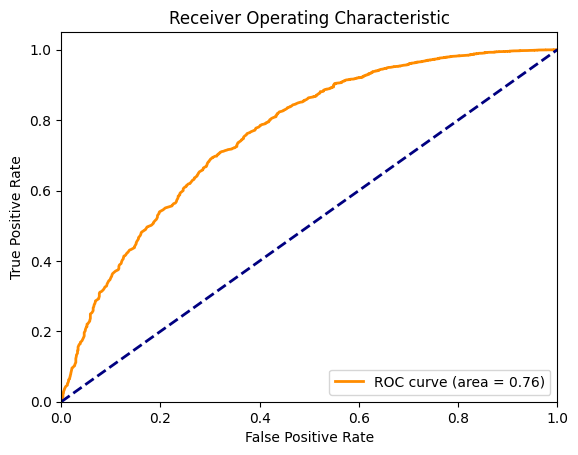

In [119]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# FPR, TPR, およびしきい値を計算する
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

# AUC（Area Under Curve）を計算する
roc_auc = auc(fpr, tpr)

# ROC曲線をプロットする
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

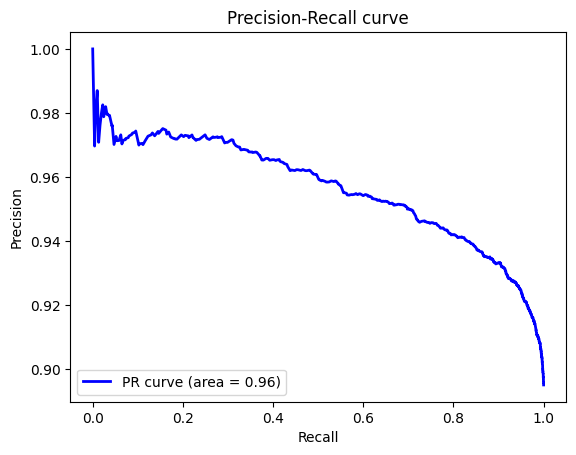

In [120]:
from sklearn.metrics import precision_recall_curve, auc

# 精度と再現率を計算
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

# PR AUCを計算
pr_auc = auc(recall, precision)

# PR曲線をプロット
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()